In [1]:
%matplotlib inline
from IPython.display import Image, display
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import common.metrics as metrics
import matplotlib
import cPickle as pkl

In [2]:
def get_env_var(handle):
    ''' Get an environment variable given the handle for the bash variable'''
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")

def show_images(list_of_images, names=None):
    for i in range(0, len(list_of_images), 1):
        imageName = list_of_images[i]
        if names:
            print(names[i])
        display(Image(filename=imageName))
        
def get_preds(data_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if data_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
    return prediction, truth

In [3]:
from common.chembl_export_data_loader import DrugMatrixDataLoader
from common.h5py_data_loader import H5pyDataLoader

In [4]:
reg_data_file = "../Plotting/regression/regression_preds_file_lookup.pkl"
with open(reg_data_file, "rb") as f:
    reg_data_dict = pkl.load(f)

In [5]:
with open("../Plotting/regression/color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("../Plotting/regression/color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)

In [6]:
def set_nice_spines(ax=None):
    if not ax:
        ax = plt.gca()
    ax.spines["left"].set_visible(True)
    ax.spines["left"].set_color("black")
    ax.spines["left"].set_linewidth(1.5)

    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color("black")
    ax.spines["bottom"].set_linewidth(1.5)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [7]:
def plot_rsquared(prediction, known_value, title="R Squared", img_filename="rsquared_{}.png", result_name='r2',
                  result_suffix='', color="blue", cmap_color="BuPu"):
    """
    Plot the r-squared between predicted and known values.
    Args:
        prediction (np.ndarray):
            value to be plotted on y-axis
        known_value (np.ndarray):
            value to be plotted on x-axis
        title (str):
            title of the plot
        img_filename (str):
            format to save as
        result_name (str):
            passed to compute_rsquared
    """
    sns.set(font_scale=1.5)
    
    t = known_value.ravel()
    nonzeros = ~np.isnan(t)
    nonzeros[nonzeros] &= t[nonzeros] > 0.0
    p = prediction.ravel()[nonzeros]
    t = t[nonzeros]
    output_dir = os.path.dirname(img_filename) if img_filename is not None else None
    logging.debug('plotting r^2')
    maxv = t.max() + 1
    g = sns.jointplot(x=p, y=t, alpha=0.5, xlim=(0, 14.5), ylim=(0, 14.5), stat_func=None, color=color)
    rsquare = metrics.compute_rsquared(p, t, output_dir=output_dir, result_name=result_name,
                                       result_suffix=result_suffix)
    g = g.annotate((lambda x,y: rsquare), template="{stat}: {val:.3f}",
                   stat="$R^2$", loc="lower right", fontsize=14)
    g.set_axis_labels("Predicted pAC50", "Known pAC50", fontsize=16)
    
    cmap = plt.cm.get_cmap(cmap_color)
    
    new_color_list = cmap(np.logspace(0.75, 1, 100))
    new_color_list[:, 3] = 0.95
    new_color_list[:-20, 3] = np.linspace(0.05, 0.9, 80)
    
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n='Al'+ cmap.name, a=0, b=100),
        new_color_list)
    
    g.ax_joint.hexbin(g.x, g.y, mincnt=2, cmap=new_cmap)

    g.fig.tight_layout()


#     if img_filename is not None:
#         logging.info('saving plot to ' + img_filename)
#         g.fig.savefig(img_filename, dpi=150)
#         plt.close(g.fig)
#     else:
    return g

# STD r-squared

In [8]:
class_expts = ["CLASSIFIER_scrambled_idx_No_SMA_LC", "CLASSIFIER_scrambled_idx_LC","CLASSIFIER_STD", "CLASSIFIER_SMA_RATIOS", ]

# prediction, truth = get_preds(data_dict, e, dset, fold, ratio=ratio)

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


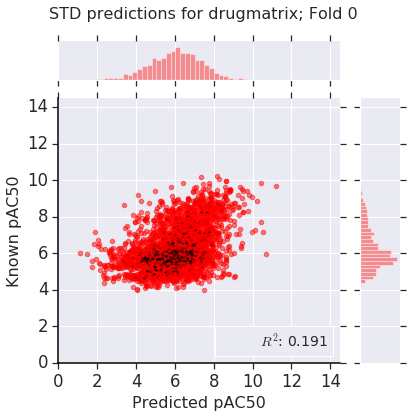

In [17]:
dm_pred, dm_known = get_preds(reg_data_dict, "STD", "drugmatrix", "0", ratio=None)
sns.set_style("whitegrid")
sns.set_context("paper")
nan_mask = np.isnan(dm_known)
g = plot_rsquared(dm_pred[~nan_mask], dm_known[~nan_mask], color="red", cmap_color="gist_heat_r", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
set_nice_spines(ax=g.ax_joint)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD", "drugmatrix", "0"), fontsize=16)

plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


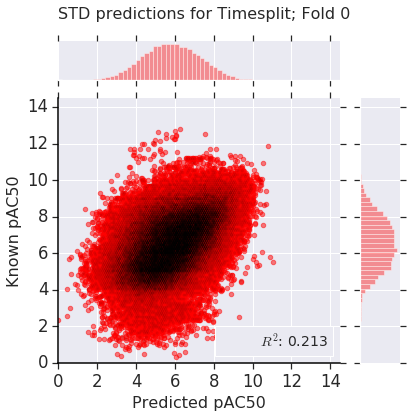

In [10]:
ts_pred, ts_known = get_preds(reg_data_dict, "STD", "timesplit", "0", ratio=None)
nan_mask = np.isnan(ts_known)
g = plot_rsquared(ts_pred[~nan_mask], ts_known[~nan_mask], color="red", cmap_color="gist_heat_r", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD", "Timesplit", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


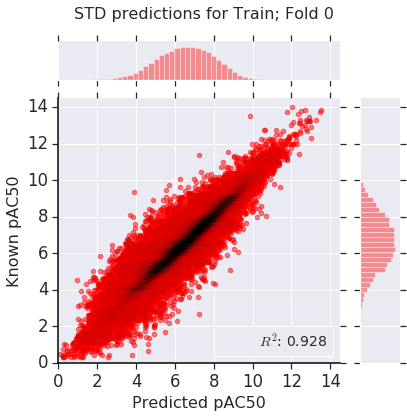

In [11]:
train_pred, train_known = get_preds(reg_data_dict, "STD", "train", "0", ratio=None)
nan_mask = np.isnan(train_known)
g = plot_rsquared(train_pred[~nan_mask], train_known[~nan_mask], color="red", cmap_color="gist_heat_r", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD", "Train", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


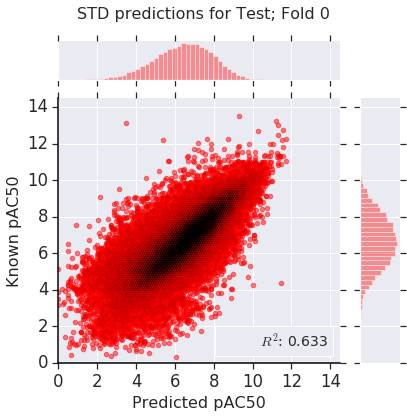

In [12]:
test_pred, test_known = get_preds(reg_data_dict, "STD", "test", "0", ratio=None)
nan_mask = np.isnan(test_known)
g = plot_rsquared(test_pred[~nan_mask], test_known[~nan_mask], color="red", cmap_color="gist_heat_r", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD", "Test", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()

# SMA plots

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


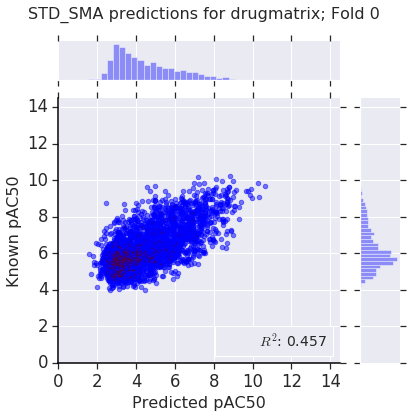

In [15]:
dm_pred, dm_known = get_preds(reg_data_dict, "STD_SMA", "drugmatrix", "0", ratio=None)
nan_mask = np.isnan(dm_known)
g = plot_rsquared(dm_pred[~nan_mask], dm_known[~nan_mask], color="blue", cmap_color="BuPu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD_SMA", "drugmatrix", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)
plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


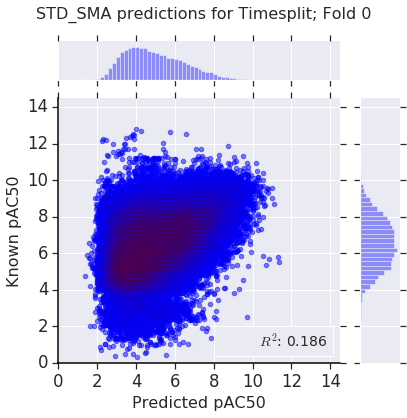

In [29]:
ts_pred, ts_known = get_preds(reg_data_dict, "STD_SMA", "timesplit", "0", ratio=None)
nan_mask = np.isnan(ts_known)
g = plot_rsquared(ts_pred[~nan_mask], ts_known[~nan_mask], color="blue", cmap_color="BuPu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD_SMA", "Timesplit", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)
plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


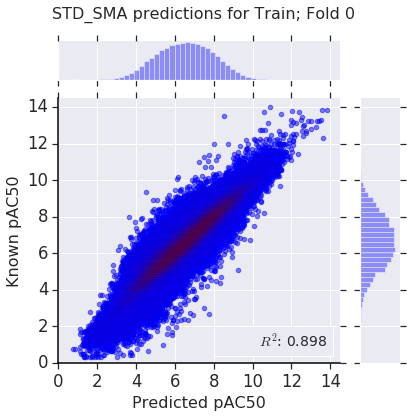

In [30]:
train_pred, train_known = get_preds(reg_data_dict, "STD_SMA", "train", "0", ratio=None)
nan_mask = np.isnan(train_known)
g = plot_rsquared(train_pred[~nan_mask], train_known[~nan_mask], color="blue", cmap_color="BuPu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD_SMA", "Train", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


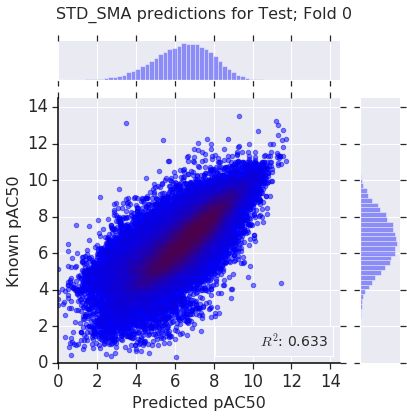

In [31]:
test_pred, test_known = get_preds(reg_data_dict, "STD", "test", "0", ratio=None)
nan_mask = np.isnan(test_known)
g = plot_rsquared(test_pred[~nan_mask], test_known[~nan_mask], color="blue", cmap_color="BuPu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("STD_SMA", "Test", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()

# Scrambled plots

In [32]:
reg_data_dict.keys()

['STD',
 'NEG_RM_SMA',
 'scrambled_idx_LC',
 'scrambled_idx',
 'STD_SMA_RATIOS',
 'NEG_RM',
 'NEG_RM_RATIOS',
 'SEA_SMA',
 'scrambled_idx_no_SMA',
 'STD_SMA',
 'scrambled_idx_no_SMA_LC']

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


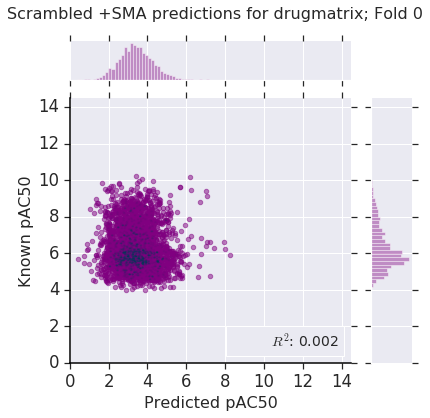

In [34]:
dm_pred, dm_known = get_preds(reg_data_dict, 'scrambled_idx_LC', "drugmatrix", "0", ratio="1.0")


nan_mask = np.isnan(dm_known)
g = plot_rsquared(dm_pred[~nan_mask], dm_known[~nan_mask], color="purple", cmap_color="PuBu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled +SMA", "drugmatrix", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)
plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


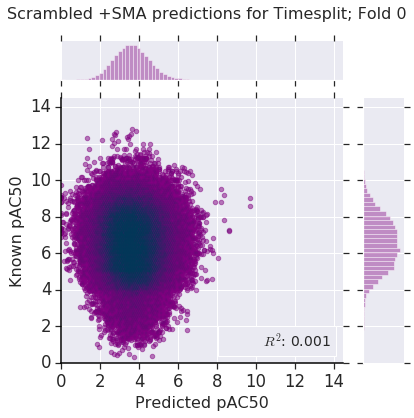

In [35]:
ts_pred, ts_known = get_preds(reg_data_dict, 'scrambled_idx_LC', "timesplit", "0", ratio="1.0")
nan_mask = np.isnan(ts_known)
g = plot_rsquared(ts_pred[~nan_mask], ts_known[~nan_mask], color="purple", cmap_color="PuBu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled +SMA", "Timesplit", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)
plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


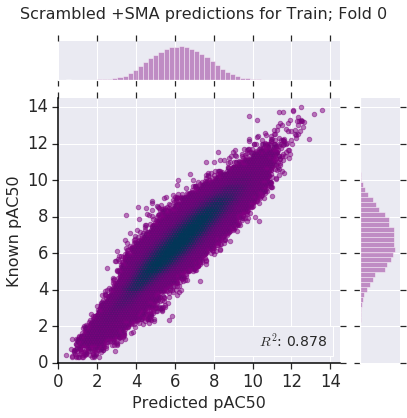

In [37]:
train_pred, train_known = get_preds(reg_data_dict, 'scrambled_idx_LC', "train", "0", ratio="1.0")
nan_mask = np.isnan(train_known)
g = plot_rsquared(train_pred[~nan_mask], train_known[~nan_mask], color="purple", cmap_color="PuBu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled +SMA", "Train", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


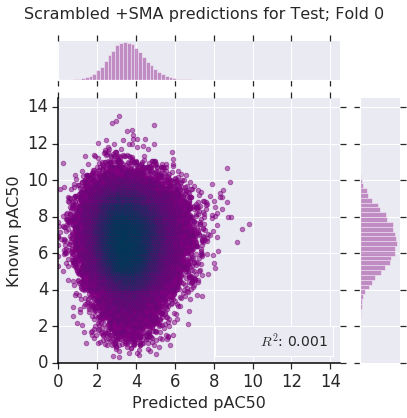

In [38]:
test_pred, test_known = get_preds(reg_data_dict, 'scrambled_idx_LC', "test", "0", ratio="1.0")
nan_mask = np.isnan(test_known)
g = plot_rsquared(test_pred[~nan_mask], test_known[~nan_mask], color="purple", cmap_color="PuBu", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled +SMA", "Test", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()

# Plain Scrambled

In [39]:
reg_data_dict.keys()

['STD',
 'NEG_RM_SMA',
 'scrambled_idx_LC',
 'scrambled_idx',
 'STD_SMA_RATIOS',
 'NEG_RM',
 'NEG_RM_RATIOS',
 'SEA_SMA',
 'scrambled_idx_no_SMA',
 'STD_SMA',
 'scrambled_idx_no_SMA_LC']

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


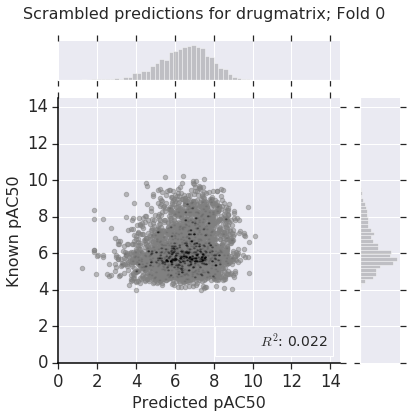

In [41]:
dm_pred, dm_known = get_preds(reg_data_dict, 'scrambled_idx_no_SMA_LC', "drugmatrix", "0", ratio="1.0")
nan_mask = np.isnan(dm_known)
g = plot_rsquared(dm_pred[~nan_mask], dm_known[~nan_mask], color="grey", cmap_color="Greys", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled", "drugmatrix", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)
plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


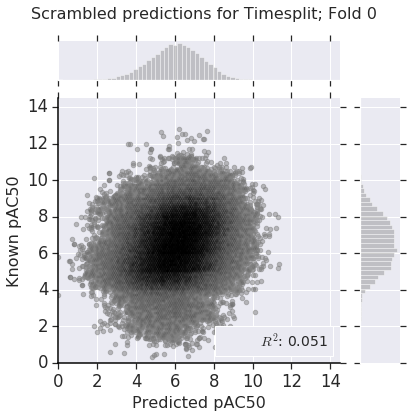

In [43]:
ts_pred, ts_known = get_preds(reg_data_dict, 'scrambled_idx_no_SMA_LC', "timesplit", "0", ratio="1.0")

nan_mask = np.isnan(ts_known)
g = plot_rsquared(ts_pred[~nan_mask], ts_known[~nan_mask], color="grey", cmap_color="Greys", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled", "Timesplit", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)
plt.show()

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


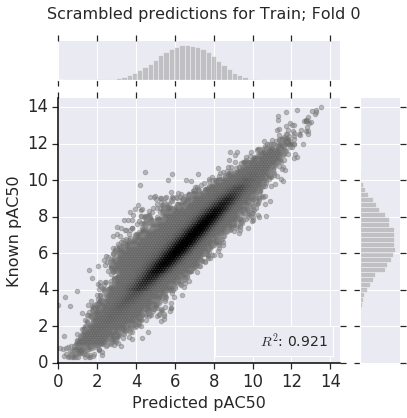

In [44]:
train_pred, train_known = get_preds(reg_data_dict, 'scrambled_idx_no_SMA_LC', "train", "0", ratio="1.0")
nan_mask = np.isnan(train_known)
g = plot_rsquared(train_pred[~nan_mask], train_known[~nan_mask], color="grey", cmap_color="Greys", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled", "Train", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()


/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


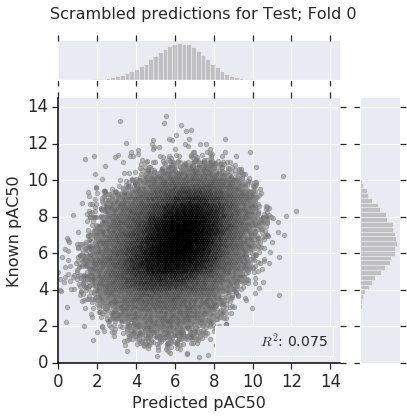

In [45]:
test_pred, test_known = get_preds(reg_data_dict, 'scrambled_idx_no_SMA_LC', "test", "0", ratio="1.0")
nan_mask = np.isnan(test_known)
g = plot_rsquared(test_pred[~nan_mask], test_known[~nan_mask], color="grey", cmap_color="Greys", 
                  img_filename=None)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('{} predictions for {}; Fold {}'.format("Scrambled", "Test", "0"), fontsize=16)
set_nice_spines(ax=g.ax_joint)

plt.show()